In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

In [4]:
from unagi import hsc
from unagi import task
from unagi import query
from unagi import config
from unagi import plotting

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


In [19]:
coord_1 = SkyCoord(150.0913, 2.205916, frame='icrs', unit='deg')
coord_2 = SkyCoord(150.1213, 2.235916, frame='icrs', unit='deg')

# Angular size
s_ang = 10.0 * u.arcsec

# Physical size
s_phy = 100.0 * u.kpc
redshift = 0.3

# Filters
filters = 'gri'

# Output dir
output_dir = 'data/'

In [26]:
# Using the physical size
# Assuming z=0.25, and we want to get a 200x200 kpc cutout
cutout = task.hsc_cutout(
    coord_1, cutout_size=s_phy, redshift=redshift, filters='i', 
    archive=pdr2, use_saved=False, output_dir=output_dir, verbose=True, 
    save_output=False)

cutout_objs = task.hsc_box_search(
    coord_1, box_size=s_phy, redshift=redshift, archive=pdr2,
    verbose=True, aper=True, shape=True)

# Retrieving cutout image in filter: i
Waiting for query to finish... [Done]


In [34]:
cutout_wcs = wcs.WCS(cutout[1].header)


In [37]:
cutout_wcs.all_world2pix(cutout_objs['ra'][0], cutout_objs['dec'][0], 1)

[array(127.58076326), array(230.95386962)]

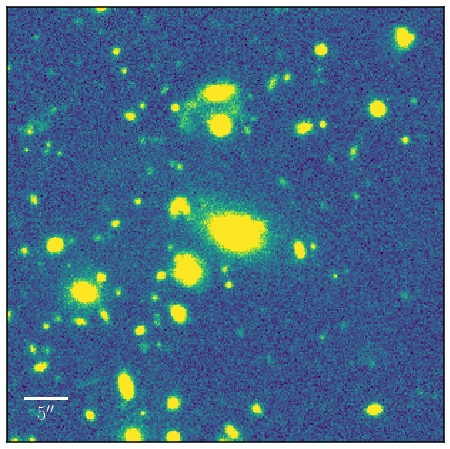

In [27]:
_ = plotting.display_single(cutout[1].data)

In [29]:
import aplpy

INFO: Auto-setting vmin to -4.214e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.309e+00 [aplpy.core]


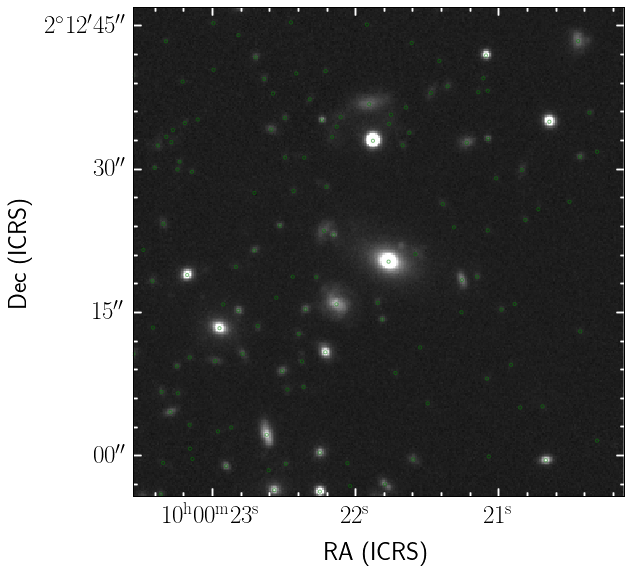

In [31]:
frame = aplpy.FITSFigure(cutout, hdu=1)
frame.show_grayscale()
frame.show_markers(cutout_objs['ra'], cutout_objs['dec'], 
                   edgecolor='green', facecolor='none', marker='o', s=10, alpha=0.5)